## 9-1 MNIST - softmax
     - Adam : SGD 대신

In [40]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [42]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [43]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [44]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [45]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [46]:
linear = torch.nn.Linear(784, 10, bias=True).to(device)

In [47]:
torch.nn.init.normal_(linear.weight) # 정규분포, 784 x 10

Parameter containing:
tensor([[-1.2901,  0.3930, -0.1891,  ..., -0.1626, -0.3275,  0.5608],
        [-1.6757, -0.2454,  0.9221,  ...,  0.9559,  0.6160, -0.4226],
        [ 0.2444,  1.4810, -2.0906,  ...,  0.1206,  1.0044, -0.3737],
        ...,
        [ 0.6234,  1.8019, -2.7563,  ..., -0.5889, -0.5576,  0.7360],
        [-0.2871, -1.3313, -2.2248,  ...,  0.0309,  0.9180, -0.1482],
        [ 0.7678,  0.6624, -0.5362,  ...,  0.2338,  0.3688, -0.7182]],
       device='cuda:0', requires_grad=True)

- Adam : gradient, learning rate 둘다 고려

In [48]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(linear.parameters(), lr=learning_rate)

In [49]:
from tqdm import tqdm_notebook as tqdm

In [50]:
total_batch = len(data_loader)
for epoch in tqdm(range(training_epochs)):
    avg_cost = 0

    for X, Y in data_loader: # 60000
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device) # 60000 x 784
        Y = Y.to(device) # 60000

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%02d' % (epoch + 1), '\t','cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 01 	 cost = 5.656054974
Epoch: 02 	 cost = 1.699803472
Epoch: 03 	 cost = 1.121566176
Epoch: 04 	 cost = 0.883357942
Epoch: 05 	 cost = 0.750486851
Epoch: 06 	 cost = 0.663246810
Epoch: 07 	 cost = 0.601343870
Epoch: 08 	 cost = 0.554267764
Epoch: 09 	 cost = 0.518746793
Epoch: 10 	 cost = 0.489619613
Epoch: 11 	 cost = 0.465846598
Epoch: 12 	 cost = 0.446371138
Epoch: 13 	 cost = 0.429083288
Epoch: 14 	 cost = 0.414352983
Epoch: 15 	 cost = 0.401432723

Learning finished


In [9]:
mnist_test.test_data.shape

torch.Size([10000, 28, 28])

In [51]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device) # 10000 x 784
    Y_test = mnist_test.test_labels.to(device) # 10000

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.8905999660491943
Label:  8
Prediction:  3


## 9-2 MNIST - NN
    - Adam
    - ReLU : sigmoid 대신

In [15]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [16]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

- ReLU : Rectified Linear Unit
    - sigmoid 를 사용하면 층이 깊어질수록 vanishing gradient 문제가 발생하게 된다. 
  ![title](Re.png)

In [17]:
linear1 = torch.nn.Linear(784, 256, bias=True)
linear2 = torch.nn.Linear(256, 256, bias=True)
linear3 = torch.nn.Linear(256, 10, bias=True)
relu = torch.nn.ReLU()

In [18]:
torch.nn.init.normal_(linear1.weight)
torch.nn.init.normal_(linear2.weight)
torch.nn.init.normal_(linear3.weight)

Parameter containing:
tensor([[-3.1874,  0.7429, -0.6153,  ..., -1.8201,  0.1607, -0.1961],
        [ 0.3986, -0.8667, -0.5681,  ...,  0.0619, -2.2653, -0.2265],
        [-1.2663,  0.8911, -0.4557,  ...,  1.8710,  0.6392, -0.3189],
        ...,
        [ 0.6468, -0.6644, -0.6639,  ...,  1.1450, -1.2163,  0.2803],
        [-1.0293,  0.2693,  0.8209,  ..., -0.3936, -0.7411,  1.0513],
        [ 3.1485,  2.3720,  2.9838,  ...,  1.5475,  0.1471, -1.6560]],
       requires_grad=True)

In [19]:
model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3).to(device)

In [20]:
criterion = torch.nn.CrossEntropyLoss().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
total_batch = len(data_loader)
for epoch in tqdm(range(training_epochs)):
    avg_cost = 0

    for X, Y in data_loader:
        
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 35.101280212
Epoch: 0002 cost = 22.568840027
Epoch: 0003 cost = 15.889390945
Epoch: 0004 cost = 11.665189743
Epoch: 0005 cost = 8.612565041
Epoch: 0006 cost = 6.470128536
Epoch: 0007 cost = 4.887979031
Epoch: 0008 cost = 3.641815424
Epoch: 0009 cost = 2.760086536
Epoch: 0010 cost = 2.111594439
Epoch: 0011 cost = 1.742623687
Epoch: 0012 cost = 1.322564125
Epoch: 0013 cost = 1.141616702
Epoch: 0014 cost = 0.857270122
Epoch: 0015 cost = 0.778423071

Learning finished


In [82]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9498999714851379
Label:  0
Prediction:  0


## 9-3 : MNIST - NN
    - Adam
    - ReLU
    - xavier initialization : 정규분포 대신

In [83]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [84]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [85]:
linear1 = torch.nn.Linear(784, 256, bias=True)
linear2 = torch.nn.Linear(256, 256, bias=True)
linear3 = torch.nn.Linear(256, 10, bias=True)
relu = torch.nn.ReLU()

- xvarier initialization : 가중치 초기화 방법 중 하나로 이전노드와 다음노드 개수에 의존한다.
    - 방법은 uniform, normal 두 가지가 있다.
   ![title](x.png)

In [86]:
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)

Parameter containing:
tensor([[-0.0598,  0.1128, -0.1468,  ..., -0.0484,  0.0354, -0.1161],
        [-0.0187,  0.1168,  0.0382,  ...,  0.0520, -0.1378,  0.0129],
        [-0.0869, -0.1015, -0.0170,  ...,  0.1181,  0.0025,  0.0385],
        ...,
        [-0.1128, -0.0081,  0.0624,  ..., -0.0698,  0.0839, -0.0214],
        [ 0.0328,  0.0814,  0.1145,  ..., -0.0209, -0.1137,  0.0286],
        [-0.1479, -0.0680, -0.0628,  ...,  0.1377, -0.0184,  0.1055]],
       requires_grad=True)

In [87]:
model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3).to(device)

In [88]:
criterion = torch.nn.CrossEntropyLoss().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [89]:
total_batch = len(data_loader)
for epoch in tqdm(range(training_epochs)):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.245592877
Epoch: 0002 cost = 0.093776651
Epoch: 0003 cost = 0.061814509
Epoch: 0004 cost = 0.045181893
Epoch: 0005 cost = 0.033410612
Epoch: 0006 cost = 0.027215190
Epoch: 0007 cost = 0.021980770
Epoch: 0008 cost = 0.017516701
Epoch: 0009 cost = 0.016731752
Epoch: 0010 cost = 0.013409850
Epoch: 0011 cost = 0.014096180
Epoch: 0012 cost = 0.011319625
Epoch: 0013 cost = 0.010022114
Epoch: 0014 cost = 0.010152928
Epoch: 0015 cost = 0.013662727

Learning finished


In [90]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9788999557495117
Label:  5
Prediction:  5


## 9-4 MNIST - NN deep + dropout
    1. Adam
    2. ReLU
    3. xavier initialization
    4. 층을 늘리고 계산도 늘어남 : 256 -> 512
    5. dropout : overffiting 방지
   ![title](d.png)

In [6]:
drop_prob = 0.3

In [7]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [100]:
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob)

In [101]:
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0347, -0.0152,  0.0010,  ...,  0.0278,  0.0165,  0.0407],
        [-0.0550, -0.0439, -0.0726,  ...,  0.0637, -0.0342,  0.0099],
        [-0.0107, -0.0572, -0.0919,  ...,  0.0434, -0.1031, -0.0155],
        ...,
        [ 0.0998,  0.0770,  0.0183,  ..., -0.0682,  0.0101,  0.0966],
        [-0.1035, -0.0221,  0.0700,  ..., -0.0634,  0.0604,  0.0396],
        [-0.0090, -0.0855,  0.0824,  ..., -0.0219, -0.0786,  0.0055]],
       requires_grad=True)

In [102]:
model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout,
                            linear4, relu, dropout,
                            linear5).to(device)

In [103]:
criterion = torch.nn.CrossEntropyLoss().to(device)    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [104]:

total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
for epoch in tqdm(range(training_epochs)):
    avg_cost = 0

    for X, Y in data_loader:
        
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.310551524
Epoch: 0002 cost = 0.142300949
Epoch: 0003 cost = 0.113023162
Epoch: 0004 cost = 0.094208725
Epoch: 0005 cost = 0.082151912
Epoch: 0006 cost = 0.074239850
Epoch: 0007 cost = 0.065893605
Epoch: 0008 cost = 0.060688630
Epoch: 0009 cost = 0.058843244
Epoch: 0010 cost = 0.051878437
Epoch: 0011 cost = 0.054459579
Epoch: 0012 cost = 0.050582249
Epoch: 0013 cost = 0.046774726
Epoch: 0014 cost = 0.047748785
Epoch: 0015 cost = 0.040831063

Learning finished


In [105]:
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.979699969291687
Label:  4
Prediction:  4


## MNIST - batch normalization
    - batch normalization vs. NN
    - gradient vanishing, gradient exploding 해결
    - internal covatiate shift -> batch normalization
   ![title](b.png)

In [18]:
import matplotlib.pylab as plt

In [19]:
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

### layer 설정

In [21]:
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

In [22]:
nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

### model 설정

In [23]:
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)

In [24]:
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [25]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: ToTensor()

### optimizer 설정

In [26]:
criterion = torch.nn.CrossEntropyLoss().to(device)   
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [27]:
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)

In [30]:
for epoch in tqdm(range(training_epochs)):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader: # 60000
        
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()
    
    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        # range와 차이?
        for (X, Y) in train_loader: # 60000
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss  = bn_loss / train_total_batch, nn_loss / train_total_batch
        bn_acc, nn_acc = bn_acc / train_total_batch, nn_acc / train_total_batch
        
        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
                
        for i, (X, Y) in enumerate(test_loader): # 10000
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()
            
            
        bn_loss, nn_loss = bn_loss / test_total_batch, nn_loss / test_total_batch
        bn_acc, nn_acc = bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.12739(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.20637(nn_acc:0.94)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.14122(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.23217(nn_acc:0.93)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.10617(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.20390(nn_acc:0.94)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.11762(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.22681(nn_acc:0.94)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09249(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17975(nn_acc:0.95)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.11243(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.21200(nn_acc:0.94)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07430(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.12588(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.09891(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17191(nn_acc:0.96)

[Epoch 5-TRAIN] Batc

### plt 사용하여 비교

In [37]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None: # return 없음
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(8, 5))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

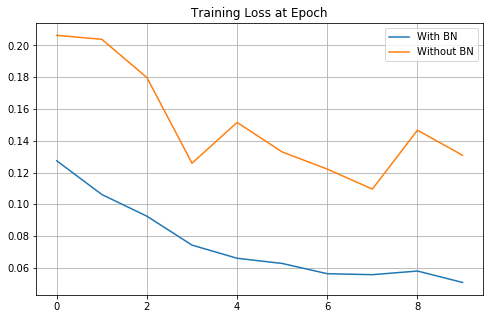

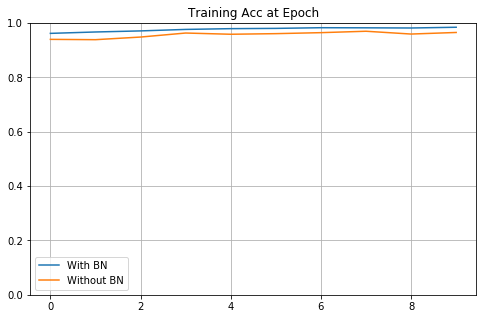

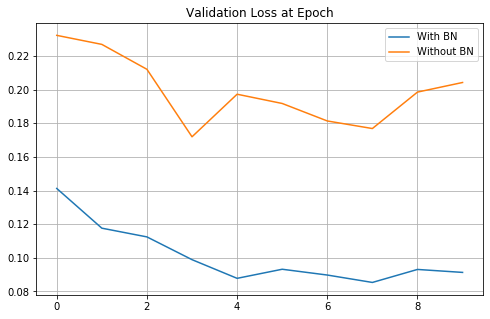

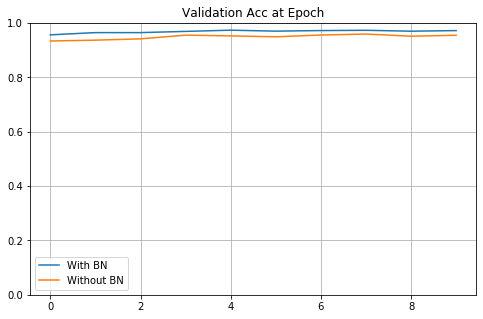

In [38]:
# train
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
# validation
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')